<a href="https://colab.research.google.com/github/shraddhapandey100/Forensic_Metadata_Analysis/blob/master/MetadataAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
!pip install pyexiftool


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.2/51.2 kB 2.0 MB/s eta 0:00:00


In [13]:
!apt-get install -y exiftool


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'libimage-exiftool-perl' instead of 'exiftool'
The following additional packages will be installed:
  libarchive-zip-perl libmime-charset-perl libsombok3 libunicode-linebreak-perl
Suggested packages:
  libposix-strptime-perl libencode-hanextra-perl libpod2-base-perl
The following NEW packages will be installed:
  libarchive-zip-perl libimage-exiftool-perl libmime-charset-perl libsombok3
  libunicode-linebreak-perl
0 upgraded, 5 newly installed, 0 to remove and 49 not upgraded.
Need to get 3,964 kB of archives.
After this operation, 23.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libarchive-zip-perl all 1.68-1 [90.2 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libimage-exiftool-perl all 12.40+dfsg-1 [3,717 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libmime-charset-perl all 1.012.2-1

**2. Media Analysis**
Purpose: Extract metadata from WhatsApp media files.
Implementation: Use the exiftool via subprocess.

In [16]:
import subprocess

def extract_metadata(file_path):
    try:
        # Run exiftool command
        result = subprocess.run(["exiftool", file_path], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

        # Check if there were errors
        if result.stderr:
            print(f"Error: {result.stderr}")
        else:
            print(result.stdout)
    except Exception as e:
        print(f"An error occurred: {e}")

# Example usage
# Upload a file to Colab before running this
extract_metadata("/content/f0000000.jpg")  # Provide the correct file path






ExifTool Version Number         : 12.40
File Name                       : f0000000.jpg
Directory                       : /content
File Size                       : 1235 KiB
File Modification Date/Time     : 2024:12:12 14:51:48+00:00
File Access Date/Time           : 2024:12:12 14:53:21+00:00
File Inode Change Date/Time     : 2024:12:12 14:53:00+00:00
File Permissions                : -rw-r--r--
File Type                       : PNG
File Type Extension             : png
MIME Type                       : image/png
Image Width                     : 968
Image Height                    : 543
Bit Depth                       : 8
Color Type                      : RGB with Alpha
Compression                     : Deflate/Inflate
Filter                          : Adaptive
Interlace                       : Noninterlaced
SRGB Rendering                  : Perceptual
Gamma                           : 2.2
Pixels Per Unit X               : 4724
Pixels Per Unit Y               : 4724
Pixel Units        

Anomaly detection analysis using the Isolation Forest algorithm.

In [17]:
import pandas as pd
from sklearn.ensemble import IsolationForest

# Load the dataset
file_path = '/content/metadata.csv'  # Replace with your actual file path
data = pd.read_csv(file_path)

# Preprocessing: Select relevant features for anomaly detection
# Using 'Size' and creating numerical mappings for categorical fields
data_cleaned = data[['Size', 'Flags(Dir)', 'Flags(Meta)', 'Known']].copy()
data_cleaned['Flags(Dir)'] = data_cleaned['Flags(Dir)'].map({'Unallocated': 0, 'Allocated': 1})
data_cleaned['Flags(Meta)'] = data_cleaned['Flags(Meta)'].map({'Unallocated': 0, 'Allocated': 1})
data_cleaned['Known'] = data_cleaned['Known'].map({'unknown': 0, 'known': 1})

# Fit Isolation Forest for anomaly detection
isolation_forest = IsolationForest(random_state=42, contamination=0.25)  # Assuming 25% anomalies
data_cleaned['Anomaly'] = isolation_forest.fit_predict(data_cleaned[['Size', 'Flags(Dir)', 'Flags(Meta)', 'Known']])

# Add anomaly labels to the original dataset for review
data['Anomaly'] = data_cleaned['Anomaly']

# Display files with anomaly labels
print(data[['Name', 'Size', 'Flags(Dir)', 'Flags(Meta)', 'Known', 'Anomaly']])

# Additional analysis for anomalies: Review anomalies separately
anomalous_files = data[data['Anomaly'] == -1]

# Output anomalous files for further investigation
print("Anomalous Files Detected:")
print(anomalous_files)


                Name    Size   Flags(Dir)  Flags(Meta)    Known  Anomaly
0       f0000000.jpg  193623  Unallocated  Unallocated  unknown       -1
1       f0000000.jpg   42917  Unallocated  Unallocated  unknown        1
2  f0000000_ftyp.mov   24799  Unallocated  Unallocated  unknown        1
3       f0000000.jpg  109181  Unallocated  Unallocated  unknown        1
Anomalous Files Detected:
           Name        Modified Time          Change Time  \
0  f0000000.jpg  0000-00-00 00:00:00  0000-00-00 00:00:00   

           Access Time         Created Time    Size   Flags(Dir)  Flags(Meta)  \
0  0000-00-00 00:00:00  0000-00-00 00:00:00  193623  Unallocated  Unallocated   

     Known                                           Location  \
0  unknown  /img_7000048698cd17764efd245fb7e9da226814cb40....   

                           MD5 Hash  \
0  6a04d27e9d3edb99d55df66db899e03a   

                                        SHA-256 Hash   MIME Type Extension  \
0  28e13322d33e41200fa6ca4d05e22bd7

**Visualization: **Visualizing anomalies with a scatter plot.

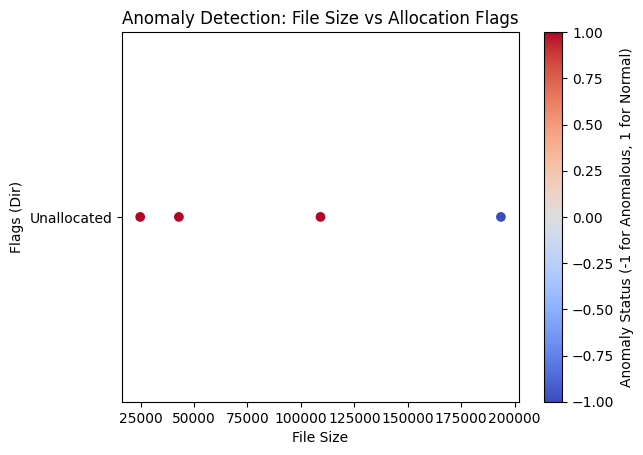

In [18]:
import matplotlib.pyplot as plt
plt.scatter(data['Size'], data['Flags(Dir)'], c=data['Anomaly'], cmap='coolwarm')
plt.xlabel('File Size')
plt.ylabel('Flags (Dir)')
plt.title('Anomaly Detection: File Size vs Allocation Flags')
plt.colorbar(label='Anomaly Status (-1 for Anomalous, 1 for Normal)')
plt.show()

a

In [19]:
import pandas as pd
from sklearn.svm import OneClassSVM
import matplotlib.pyplot as plt

# Load the dataset
file_path = '/content/metadata.csv'  # Replace with your actual file path
data = pd.read_csv(file_path)

# Preprocessing: Select relevant features for anomaly detection
data_cleaned = data[['Size', 'Flags(Dir)', 'Flags(Meta)', 'Known']].copy()
data_cleaned['Flags(Dir)'] = data_cleaned['Flags(Dir)'].map({'Unallocated': 0, 'Allocated': 1})
data_cleaned['Flags(Meta)'] = data_cleaned['Flags(Meta)'].map({'Unallocated': 0, 'Allocated': 1})
data_cleaned['Known'] = data_cleaned['Known'].map({'unknown': 0, 'known': 1})

# Fit One-Class SVM for anomaly detection
ocsvm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.25)  # nu=0.25 is an assumed anomaly fraction
data_cleaned['Anomaly'] = ocsvm.fit_predict(data_cleaned[['Size', 'Flags(Dir)', 'Flags(Meta)', 'Known']])

# Add anomaly labels to the original dataset
data['Anomaly'] = data_cleaned['Anomaly']

# Display files with anomaly labels
print(data[['Name', 'Size', 'Flags(Dir)', 'Flags(Meta)', 'Known', 'Anomaly']])

# Additional analysis for anomalies: Review anomalies separately
anomalous_files = data[data['Anomaly'] == -1]

# Output anomalous files for further investigation
print("Anomalous Files Detected:")
print(anomalous_files)


                Name    Size   Flags(Dir)  Flags(Meta)    Known  Anomaly
0       f0000000.jpg  193623  Unallocated  Unallocated  unknown        1
1       f0000000.jpg   42917  Unallocated  Unallocated  unknown        1
2  f0000000_ftyp.mov   24799  Unallocated  Unallocated  unknown       -1
3       f0000000.jpg  109181  Unallocated  Unallocated  unknown        1
Anomalous Files Detected:
                Name        Modified Time          Change Time  \
2  f0000000_ftyp.mov  0000-00-00 00:00:00  0000-00-00 00:00:00   

           Access Time         Created Time   Size   Flags(Dir)  Flags(Meta)  \
2  0000-00-00 00:00:00  0000-00-00 00:00:00  24799  Unallocated  Unallocated   

     Known                                           Location  \
2  unknown  /img_IMG-20240130-WA0001.mp4/$CarvedFiles/1/f0...   

                           MD5 Hash  \
2  91c8f86ccc6a9d1dc200d512716e7ce1   

                                        SHA-256 Hash        MIME Type  \
2  43a4027659381a2c27c021a374378

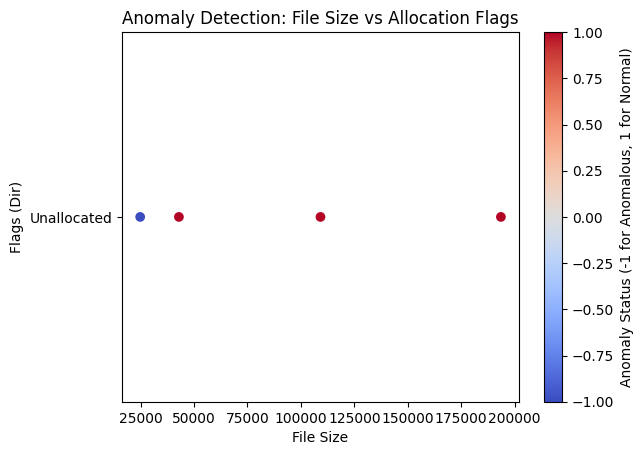

In [20]:

# Optional: Visualizing anomalies with a scatter plot.
plt.scatter(data['Size'], data['Flags(Dir)'], c=data['Anomaly'], cmap='coolwarm')
plt.xlabel('File Size')
plt.ylabel('Flags (Dir)')
plt.title('Anomaly Detection: File Size vs Allocation Flags')
plt.colorbar(label='Anomaly Status (-1 for Anomalous, 1 for Normal)')
plt.show()

K-means Algorithm.

In [22]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load the dataset
file_path = '/content/metadata.csv'  # Replace with your actual file path
data = pd.read_csv(file_path)

# Preprocess the data
data_cleaned = data[['Size', 'Flags(Dir)', 'Flags(Meta)', 'Known']].copy()
data_cleaned['Flags(Dir)'] = data_cleaned['Flags(Dir)'].map({'Unallocated': 0, 'Allocated': 1})
data_cleaned['Flags(Meta)'] = data_cleaned['Flags(Meta)'].map({'Unallocated': 0, 'Allocated': 1})
data_cleaned['Known'] = data_cleaned['Known'].map({'unknown': 0, 'known': 1})

# K-Means Anomaly Detection (for example, 3 clusters)
kmeans = KMeans(n_clusters=3)
kmeans.fit(data_cleaned[['Size', 'Flags(Dir)', 'Flags(Meta)', 'Known']])

# Predict clusters and calculate distances from centroids
data['KMeans_Cluster'] = kmeans.predict(data_cleaned[['Size', 'Flags(Dir)', 'Flags(Meta)', 'Known']])
distances = kmeans.transform(data_cleaned[['Size', 'Flags(Dir)', 'Flags(Meta)', 'Known']])

# Calculate minimum distance to the centroid for each point
data['KMeans_Distances'] = distances.min(axis=1)

# Define anomalies as points far from centroids (for example, greater than the 95th percentile of distances)
threshold = data['KMeans_Distances'].quantile(0.95)
data['KMeans_Anomaly'] = data['KMeans_Distances'] > threshold

# Display results
print(data[['Name', 'Size', 'Flags(Dir)', 'Flags(Meta)', 'Known', 'KMeans_Cluster', 'KMeans_Anomaly']])


                Name    Size   Flags(Dir)  Flags(Meta)    Known  \
0       f0000000.jpg  193623  Unallocated  Unallocated  unknown   
1       f0000000.jpg   42917  Unallocated  Unallocated  unknown   
2  f0000000_ftyp.mov   24799  Unallocated  Unallocated  unknown   
3       f0000000.jpg  109181  Unallocated  Unallocated  unknown   

   KMeans_Cluster  KMeans_Anomaly  
0               0           False  
1               1           False  
2               1           False  
3               2           False  


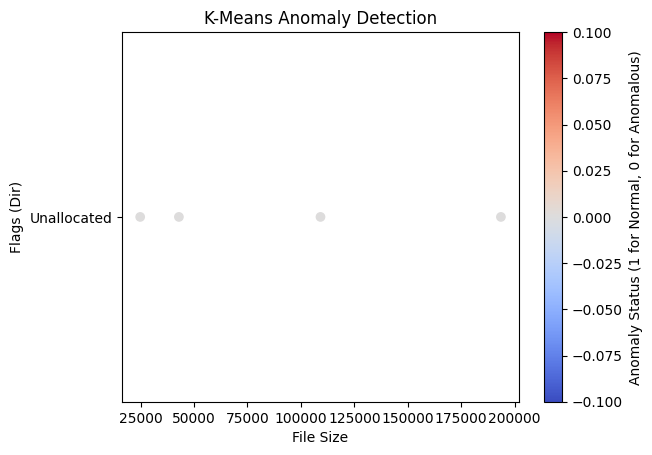

In [23]:

#Visualizing K-Means anomalies
plt.scatter(data['Size'], data['Flags(Dir)'], c=data['KMeans_Anomaly'], cmap='coolwarm')
plt.xlabel('File Size')
plt.ylabel('Flags (Dir)')
plt.title('K-Means Anomaly Detection')
plt.colorbar(label='Anomaly Status (1 for Normal, 0 for Anomalous)')
plt.show()

**6. Report Generation**
JSON (Python json module)
Purpose: Structure forensic data.

In [24]:
import json
import pandas as pd

# Load the dataset
file_path = '/content/metadata.csv'  # Replace with your actual file path
data = pd.read_csv(file_path)

# Preprocess the data if needed (mapping the categorical variables to numeric or other formats)
data_cleaned = data[['Name', 'Size', 'Flags(Dir)', 'Flags(Meta)', 'Known']].copy()
data_cleaned['Flags(Dir)'] = data_cleaned['Flags(Dir)'].map({'Unallocated': 0, 'Allocated': 1})
data_cleaned['Flags(Meta)'] = data_cleaned['Flags(Meta)'].map({'Unallocated': 0, 'Allocated': 1})
data_cleaned['Known'] = data_cleaned['Known'].map({'unknown': 0, 'known': 1})

# Initialize a list to store forensic report data
forensic_reports = []

# Iterate over each row in the cleaned data to create the forensic report
for index, row in data_cleaned.iterrows():
    report_data = {
        "File": row['Name'],
        "Metadata": {
            "Size": row['Size'],
            "Flags(Dir)": row['Flags(Dir)'],
            "Flags(Meta)": row['Flags(Meta)'],
            "Known": row['Known']
        }
    }
    forensic_reports.append(report_data)

# Save the reports as a JSON file
json_file_path = 'forensic_report.json'  # Output path for JSON file
with open(json_file_path, "w") as file:
    json.dump(forensic_reports, file, indent=4)

print(f"Report saved to {json_file_path}")


Report saved to forensic_report.json
